# FATES MRV IFM sites

#### Libraries

In [135]:
import numpy as np
import xarray as xr
import csv
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm

from scipy.optimize import curve_fit
from scipy.stats import linregress

## Read in the data from Mexico's National Forest and Soils  Inventory (INFyS)
- Note we are using 2015-2020 data
- We only read in plots from the state of Puebla
- We could filter by altitude? 

In [136]:
df_all = pd.read_csv('/Users/JFNeedham/Desktop/Mexico_forest_inventory_data-FATES-MRV/INFyS_2015_2020_Puebla_subset.csv', low_memory=False)
df_all = df_all.dropna(subset=['Genus'])

In [137]:
df_all.head(10)

,Genus,Species,dbh,height,CA,agb,lat,lon,Latin
0,Mimosa,benthamii,8.7,5.2,5.105100,15.266167,-98.557139,17.980417,Mimosa benthamii
1,Mimosa,benthamii,8.9,4.9,7.068600,15.947983,-98.557139,17.980417,Mimosa benthamii
2,unknown,unknown,21.0,0.2,999993.000000,1.926283,-98.557139,17.980417,unknown unknown
3,unknown,unknown,11.8,0.2,999993.000000,0.608199,-98.557139,17.980417,unknown unknown
4,Heliocarpus,velutinus,9.5,5.8,6.377448,16.354435,-98.557139,17.980417,Heliocarpus velutinus
5,Mimosa,benthamii,10.7,6.0,9.079224,22.724136,-98.557139,17.980417,Mimosa benthamii
6,Lysiloma,acapulcense,11.4,5.1,8.042496,51.168932,-98.557139,17.980417,Lysiloma acapulcense
7,Garrya,unknown,13.5,5.6,9.896040,45.231000,-98.273694,17.973528,Garrya unknown
8,unknown,unknown,8.4,1.4,999991.000000,1.438291,-98.273694,17.973528,unknown unknown
9,Bursera,unknown,20.9,7.2,8.042496,40.998185,-98.273694,17.973528,Bursera unknown


#### Evergreen PFT - pines and firs known to be in the San Rafael site

In [138]:
species = ['Pinus teocote','Pinus montezumae','Pinus leiophylla','Pinus hartwegii','Abies religiosa', 'Pinus ayacahuite']
evergreen = df_all[df_all['Latin'].str.contains('|'.join(species))]
print(len(evergreen))
evergreen.head(5)

507


,Genus,Species,dbh,height,CA,agb,lat,lon,Latin
4426,Pinus,leiophylla,39.3,13.1,52.166268,758.795199,-98.628444,18.932361,Pinus leiophylla
4970,Pinus,hartwegii,27.3,10.2,15.550920,234.177315,-98.623917,19.113472,Pinus hartwegii
5096,Abies,religiosa,24.5,20.1,12.566400,252.100646,-97.341306,18.988722,Abies religiosa
5097,Abies,religiosa,35.1,27.2,33.693660,622.237774,-97.341306,18.988722,Abies religiosa
5098,Abies,religiosa,20.8,8.2,29.703828,167.067798,-97.341306,18.988722,Abies religiosa


#### Oaks 

In [139]:
oaks = df_all[df_all['Genus'].str.contains('Quercus')]
print(len(oaks))
oaks.head(5)

1673


,Genus,Species,dbh,height,CA,agb,lat,lon,Latin
93,Quercus,unknown,10.6,5.1,12.880560,29.149596,-98.360028,18.292361,Quercus unknown
151,Quercus,glaucoides,24.4,6.0,16.619064,182.869626,-98.500528,18.340972,Quercus glaucoides
152,Quercus,unknown,8.0,6.0,1.649340,14.877727,-98.500528,18.340972,Quercus unknown
153,Quercus,unknown,22.3,7.9,9.896040,172.424966,-98.500528,18.340972,Quercus unknown
156,Quercus,glaucoides,29.7,4.2,15.550920,333.103946,-98.500528,18.340972,Quercus glaucoides


### Functions

In [140]:
def d2hmc (d, p1, p2, p3) :
    h = (p1 * d**p2) / (p3 + d**p2)
    return h

initial_guess_h = [58.0, 0.73, 21.8]


In [141]:
def d2ca (d, p1, p2) :
    ca = p1 * d ** p2
    return ca

initial_guess_ca = [0.07, 1.3]

In [142]:
def d2bagw (d, p1, p2) :
    bagw = (p1 * d**p2) 
    return bagw

# Note in FATES this is divided by 2 to get carbon. But measurements are in biomass. 

### Height

In [143]:
evg_h = evergreen.dropna(subset=['height', 'dbh'])
# remove outliers
evg_h = evg_h[evg_h['dbh'] < 1000]
dbh_evg_h = np.arange(1,evg_h['dbh'].max(),1)

height_ps_evg, height_cov_evg = curve_fit(f=d2hmc, xdata=np.array(evg_h['dbh']), ydata=np.array(evg_h['height']),
                                           p0=initial_guess_h)
evg_curve_h = [d2hmc(d, height_ps_evg[0], height_ps_evg[1], height_ps_evg[2])  for  d  in dbh_evg_h]
print(height_ps_evg)


[47.02238834  1.01099235 61.65702984]


In [144]:
oak_h = oaks.dropna(subset=['height', 'dbh'])
# remove outliers
oak_h = oak_h[oak_h['dbh'] < 1000]
oak_h = oak_h[oak_h['height'] < 1000]
dbh_oak_h = np.arange(1,oak_h['dbh'].max(),1)

height_ps_oak, height_cov_oak = curve_fit(f=d2hmc, xdata=np.array(oak_h['dbh']), ydata=np.array(oak_h['height']),
                                           p0=initial_guess_h)
oak_curve_h = [d2hmc(d, height_ps_oak[0], height_ps_oak[1], height_ps_oak[2])  for  d  in dbh_oak_h]
print(height_ps_oak)

[4.65190002e+06 5.45156688e-01 2.78119229e+06]


Text(0.5, 0, 'DBH (cm)')

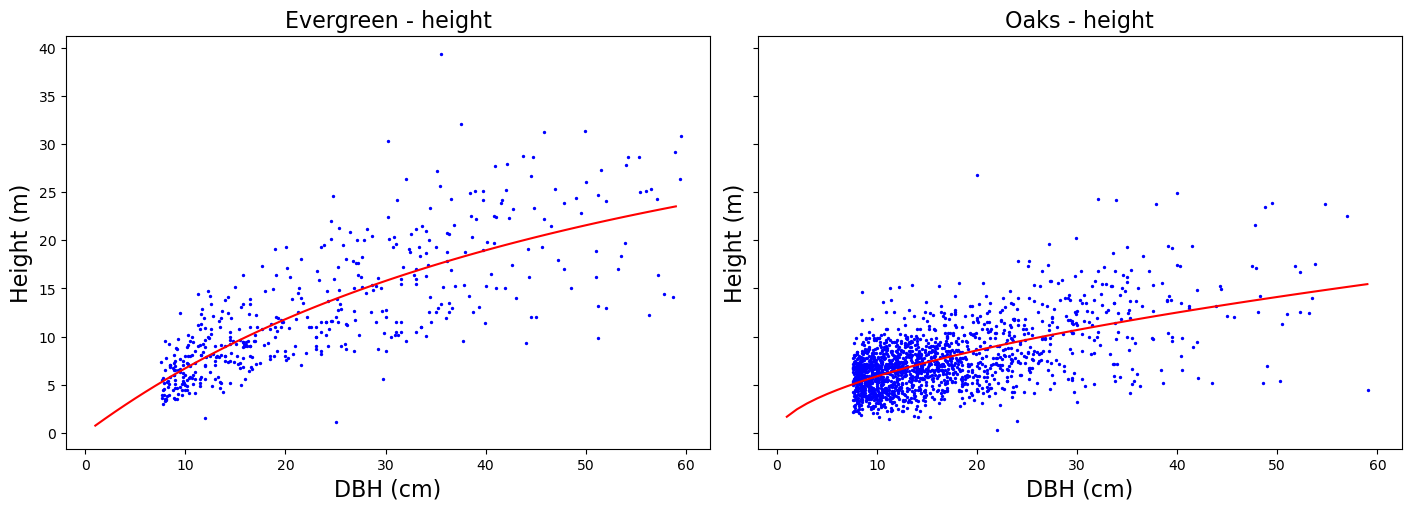

In [145]:
fig, ((fax0,fax1)) = plt.subplots(nrows=1, ncols=2, figsize=(14,5), sharey=True, sharex=True, constrained_layout=True)

fax0.scatter(evg_h.dbh, evg_h.height, c='blue', s=2)
fax0.plot(dbh_evg_h, evg_curve_h, color='red')
fax0.set_title('Evergreen - height', fontsize=16)
fax0.set_ylabel('Height (m)', fontsize=16)
fax0.set_xlabel('DBH (cm)', fontsize=16)

fax1.scatter(oak_h.dbh, oak_h.height, c='blue', s=2)
fax1.plot(dbh_oak_h, oak_curve_h, color='red')
fax1.set_title('Oaks - height', fontsize=16)
fax1.set_ylabel('Height (m)', fontsize=16)
fax1.set_xlabel('DBH (cm)', fontsize=16)



### Crown area 

In [146]:
evg_ca = evergreen.dropna(subset=['CA','dbh'])
# remove outliers
evg_ca = evg_ca[evg_ca['dbh'] < 1000]
evg_ca = evg_ca[evg_ca['CA'] < 1000]
dbh_evg_ca = np.arange(1,evg_ca['dbh'].max(),1)

ca_ps_evg, ca_cov_evg = curve_fit(f=d2ca, xdata=np.array(evg_ca['dbh']), ydata=np.array(evg_ca['CA']), p0=initial_guess_ca)

evg_curve_ca = [d2ca(d, ca_ps_evg[0], ca_ps_evg[1])  for  d  in dbh_evg_ca]

print(ca_ps_evg)

[0.41284662 1.24382974]


In [147]:
oak_ca = oaks.dropna(subset=['CA','dbh'])
# remove outliers
oak_ca = oak_ca[oak_ca['dbh'] < 1000]
oak_ca = oak_ca[oak_ca['CA'] < 1000]
dbh_oak_ca = np.arange(1,oak_ca['dbh'].max(),1)

ca_ps_oak, ca_cov_oak = curve_fit(f=d2ca, xdata=np.array(oak_ca['dbh']), ydata=np.array(oak_ca['CA']), p0=initial_guess_ca)

oak_curve_ca = [d2ca(d, ca_ps_oak[0], ca_ps_oak[1])  for  d  in dbh_oak_ca]

print(ca_ps_oak)

[0.59158659 1.15360042]


Text(0.5, 0, 'DBH (cm)')

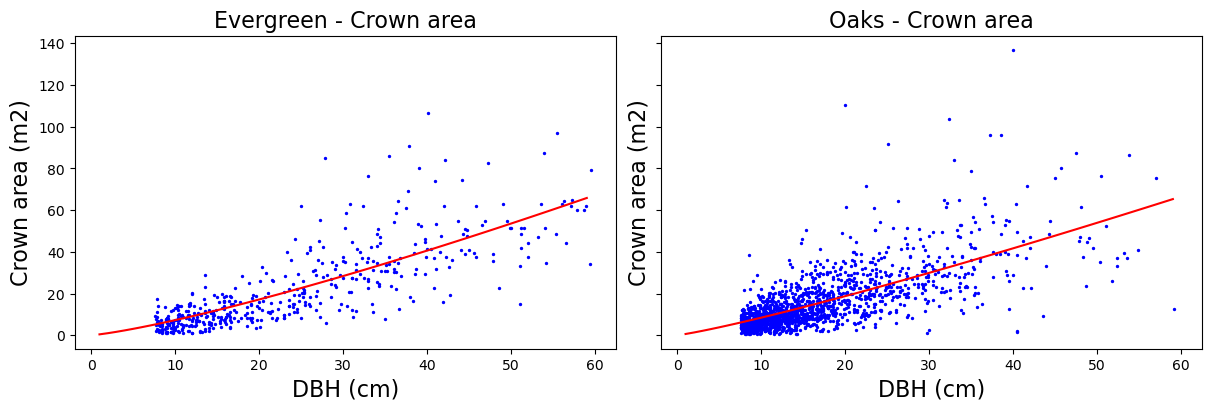

In [148]:
fig, ((fax0,fax1)) = plt.subplots(nrows=1, ncols=2, 
                                  figsize=(12,4), sharey=True, sharex=True, constrained_layout=True)

fax0.scatter(evg_ca.dbh, evg_ca.CA, c='blue', s=2)
fax0.plot(dbh_evg_ca, evg_curve_ca, color='red')
fax0.set_title('Evergreen - Crown area', fontsize=16)
fax0.set_ylabel('Crown area (m2)', fontsize=16)
fax0.set_xlabel('DBH (cm)', fontsize=16)

fax1.scatter(oak_ca.dbh, oak_ca.CA, c='blue', s=2)
fax1.plot(dbh_oak_ca, oak_curve_ca, color='red')
fax1.set_title('Oaks - Crown area', fontsize=16)
fax1.set_ylabel('Crown area (m2)', fontsize=16)
fax1.set_xlabel('DBH (cm)', fontsize=16)



### Biomass

Use power function with parameters from Návar 2009 Forest Ecology and Management, a = 0.1229, b = 2.3964 for Pine and a = 0.0890, b = 2.5226 for Oaks. 

In [149]:
evg_agb = evergreen.dropna(subset=['agb','dbh'])
# remove outliers
evg_agb = evg_agb[evg_agb['dbh'] < 1000]
evg_agb = evg_agb[evg_agb['agb'] < 5000]
dbh_evg_agb = np.arange(1,evg_agb['dbh'].max(),1)

evg_curve_agb = [d2bagw(d, 0.1229, 2.3964)  for  d  in dbh_evg_agb]

oak_agb = oaks.dropna(subset=['agb','dbh'])
# remove outliers
oak_agb = oak_agb[oak_agb['dbh'] < 1000]
oak_agb = oak_agb[oak_agb['agb'] < 5000]
dbh_oak_agb = np.arange(1,oak_agb['dbh'].max(),1)

oak_curve_agb = [d2bagw(d, 0.1229, 2.3964)  for  d  in dbh_oak_agb]



Text(0.5, 0, 'DBH (cm)')

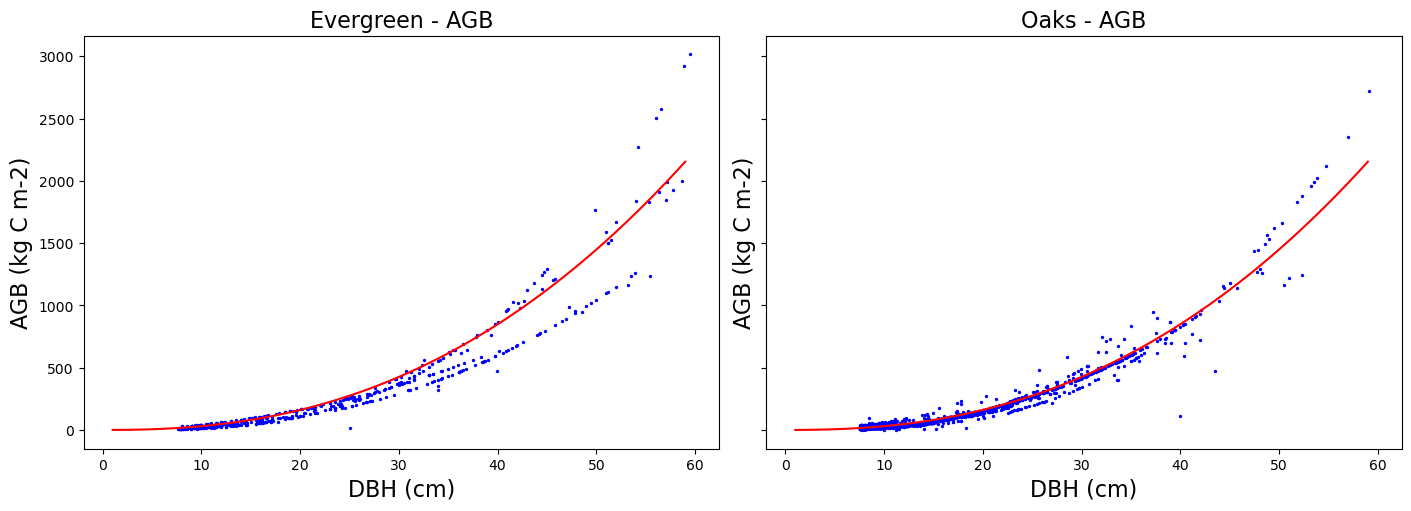

In [150]:
fig, ((fax0,fax1)) = plt.subplots(nrows=1, ncols=2, figsize=(14,5), sharey=True, sharex=True, constrained_layout=True)

fax0.scatter(evg_agb.dbh, evg_agb.agb, c='blue', s=2)
fax0.plot(dbh_evg_agb, evg_curve_agb, color='red')
fax0.set_title('Evergreen - AGB', fontsize=16)
fax0.set_ylabel('AGB (kg C m-2)', fontsize=16)
fax0.set_xlabel('DBH (cm)', fontsize=16)

fax1.scatter(oak_agb.dbh, oak_agb.agb, c='blue', s=2)
fax1.plot(dbh_oak_agb, oak_curve_agb, color='red')
fax1.set_title('Oaks - AGB', fontsize=16)
fax1.set_ylabel('AGB (kg C m-2)', fontsize=16)
fax1.set_xlabel('DBH (cm)', fontsize=16)



### Leaf biomass 

In [159]:
def d2bl (d, p1, p2) : 
    blmax = (p1 * d **  p2) / 2.0
    return blmax

### LAI 

In [160]:
def decay_coeff_kn ( vcmax25top ) :
    kn = np.exp(0.00963 * vcmax25top  - 2.43)
    return kn

In [161]:
def tree_lai ( leaf_c, c_area, vcmax25top, slatop, slamax) :
    
    g_per_kg = 1000.0
    slat = g_per_kg * slatop
    leafc_per_unitarea = leaf_c / c_area
    canopy_lai_above = 0
        
    kn = decay_coeff_kn(vcmax25top)
    sla_max = g_per_kg * slamax
    leafc_slamax = (slat - sla_max * np.exp(-1.0 * kn * canopy_lai_above)) / (
        -1.0 * kn * slat * sla_max) 
    
    if (leafc_per_unitarea <= leafc_slamax) : 
        tree_lai = (np.log (np.exp(-1 * kn * canopy_lai_above) - kn * slat  * leafc_per_unitarea) + 
                    (kn * canopy_lai_above)) / (-1 * kn)
    else : 
        tree_lai = ((np.log (np.exp(1 * kn * canopy_lai_above) - kn * slat * leafc_slamax) + 
                     (kn * canopy_lai_above)) / (-1 * kn))  +  (leafc_per_unitarea -
                                                                leafc_slamax) * sla_max
        
    return tree_lai

In [179]:
vcmax25top = [61,62]
nitr_stoich  = [0.033, 0.029]
slatop = [0.0108, 0.006]
slamax= [0.0954, 0.0954]
lnc_top =  [a / b for a,  b  in  zip(nitr_stoich,  slatop)]
umolC_to_kgC = 12.0e-9
g_per_kg = 1000.0

ca_p1 = [ca_ps_evg[0], ca_ps_oak[0]]
ca_p2 =  [ca_ps_evg[1], ca_ps_oak[1]]

d2bl1 = [0.04, 0.08]
d2bl2 = [a * 1.2 for a in ca_p2]
print(d2bl2)

diffs = [a - b for a,b in zip(ca_p1, d2bl2)]
print(diffs)

pftnames = ['Pines', 'Oaks']

[1.4925956877398388, 1.3843205073210374]
[-1.0797490661878684, -0.7927339150748909]


''

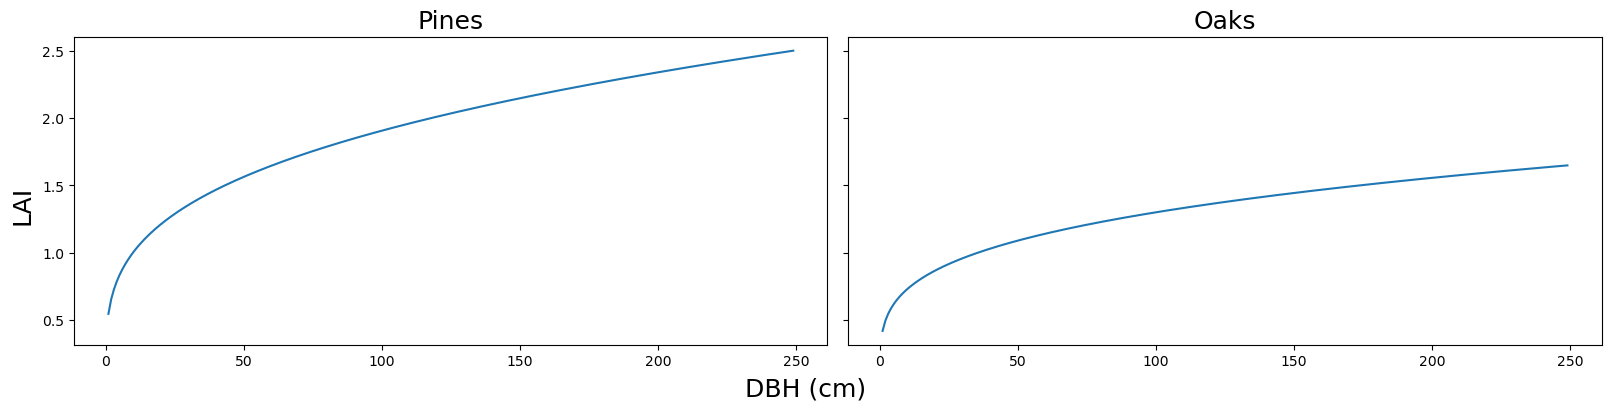

In [177]:
fig2, axs = plt.subplots(nrows=1,ncols=2,
                        figsize=(16,4), constrained_layout=True, sharex=True, sharey=True)

axs = axs.flatten()

# for each tree PFT calculate total vai
for pf in range(0, 2) : 
    
    dbh = np.arange(1,250,1)
    
    # calculate leaf carbon
    bleaf_curve = [d2bl(d, d2bl1[pf], d2bl2[pf])  for  d  in dbh]
    
    # calculate crown area
    ca_curve = [d2ca(d, ca_p1[pf],  ca_p2[pf])  for  d  in dbh]
    
    lai_curve = [tree_lai( leaf_c, c_area, vcmax25top[pf], slatop[pf], slamax[pf])
             for leaf_c, c_area in zip(bleaf_curve, ca_curve)]
    
    axs[pf].plot(dbh, lai_curve)
    axs[pf].set_title(pftnames[pf], fontsize=18)

fig2.supylabel('LAI', fontsize=18)
fig2.supxlabel('DBH (cm)', fontsize=18)  
;

1.243829739783199
1.1536004227675312


Text(0.5, 0, 'DBH (cm)')

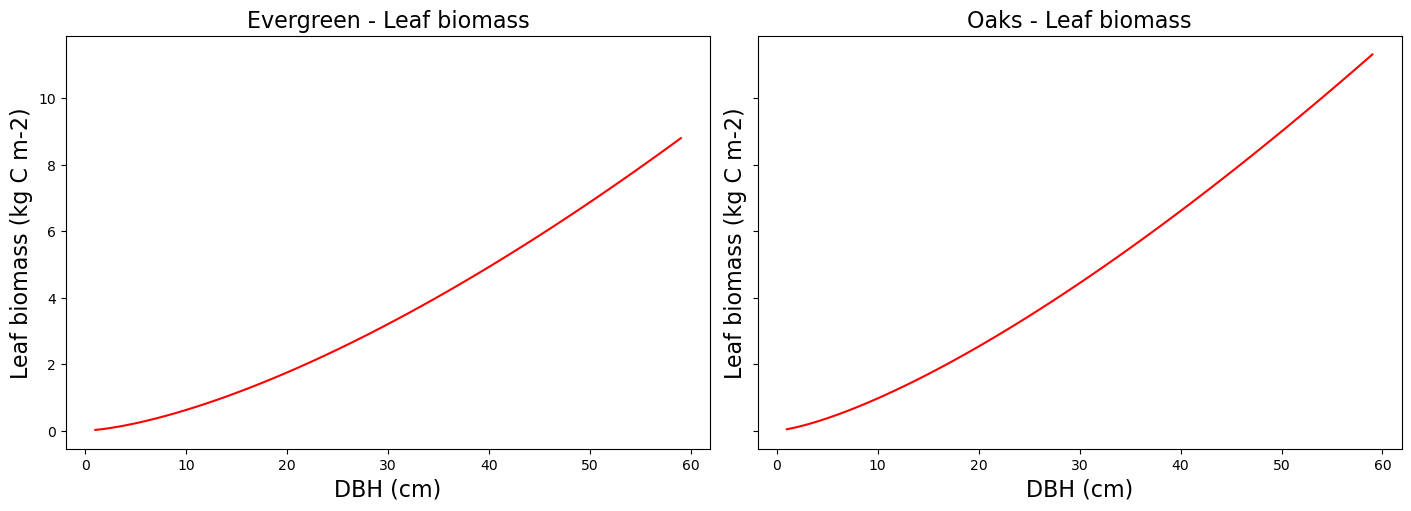

In [178]:
evg_curve_bl = [d2bl(d, d2bl1[0], d2bl2[0])  for  d  in dbh_evg_agb]
print(ca_ps_evg[1])

oak_curve_bl = [d2bl(d, d2bl1[1], d2bl2[1])  for  d  in dbh_oak_agb]
print(ca_ps_oak[1])

fig, ((fax0,fax1)) = plt.subplots(nrows=1, ncols=2, figsize=(14,5), sharey=True, sharex=True, constrained_layout=True)

fax0.plot(dbh_evg_agb, evg_curve_bl, color='red')
fax0.set_title('Evergreen - Leaf biomass', fontsize=16)
fax0.set_ylabel('Leaf biomass (kg C m-2)', fontsize=16)
fax0.set_xlabel('DBH (cm)', fontsize=16)

fax1.plot(dbh_oak_agb, oak_curve_bl, color='red')
fax1.set_title('Oaks - Leaf biomass', fontsize=16)
fax1.set_ylabel('Leaf biomass (kg C m-2)', fontsize=16)
fax1.set_xlabel('DBH (cm)', fontsize=16)
